In [13]:
%reload_ext autoreload
%autoreload 2

In [14]:
import sys
sys.path.append('../..')

In [15]:
import torch
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cuda:1'
device

'cuda:1'

In [16]:
from src.infra import config

path = '../../config/vec.yaml'
opt = config.load_config(path)
opt.path = path

## Dataset

In [17]:
from src.dataset.shape_cor_fast import PairFaustDatasetFast

dataset = PairFaustDatasetFast(
    data_root='../../data_/FAUST_r',
    phase='train',
    return_faces=True,
    return_L=True,
    return_mass=True,
    num_evecs=200,
    return_evecs=True,
    return_grad=True,
    return_corr=False,
    return_dist=False,
)
len(dataset)

6400

In [18]:
from src.network.urssm import URSSM_vectorized

network = URSSM_vectorized(opt=opt).to(device)
network

URSSM_vectorized(
  (point_descriptor): WKS_vectorized()
  (feature_extractor): DiffusionNet_vectorized(
    (first_lin): Linear(in_features=128, out_features=128, bias=True)
    (last_lin): Linear(in_features=128, out_features=256, bias=True)
    (block_0): DiffusionNetBlock(
      (diffusion): LearnedTimeDiffusion()
      (gradient_features): SpatialGradientFeatures(
        (A_re): Linear(in_features=128, out_features=128, bias=False)
        (A_im): Linear(in_features=128, out_features=128, bias=False)
      )
      (mlp): MiniMLP(
        (miniMLP_mlp_layer_000): Linear(in_features=384, out_features=128, bias=True)
        (miniMLP_mlp_act_000): ReLU()
        (miniMLP_mlp_layer_dropout_001): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_001): Linear(in_features=128, out_features=128, bias=True)
        (miniMLP_mlp_act_001): ReLU()
        (miniMLP_mlp_layer_dropout_002): Dropout(p=0.5, inplace=False)
        (miniMLP_mlp_layer_002): Linear(in_features=128, out_feature

In [19]:
import time
import torch
from src.dataloader.shape_cor_batch import BatchShapePairDataLoader
from src.utils.tensor import to_device

run_batch_num = 10
log = []

for batch_size in range(1, 17):
    batch_loader = BatchShapePairDataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=4 if batch_size > 1 else 0,
    )

    start_time = time.time()

    for idx, batch in enumerate(batch_loader):
        batch = to_device(batch, device)
        infer = network(batch)

        del batch, infer  # Explicitly release memory
        torch.cuda.empty_cache()
        
        if idx >= run_batch_num:
            break

    end_time = time.time()
    duration = end_time - start_time
    batch_throughput = run_batch_num / duration
    sample_throughput = batch_throughput * batch_size
    eta = len(batch_loader) / batch_throughput / 60

    print(f'batch: {batch_size} | num_batch: {len(batch_loader)} | {batch_throughput:.2f} batch/s | {sample_throughput:.2f} sample/s | ETA: {eta:.2f} min')
    
    log.append({
        'batch_size': batch_size,
        'num_batch': len(batch_loader),
        'batch_throughput': batch_throughput,
        'sample_throughput': sample_throughput,
        'eta': eta,
    })

    del batch_loader
    torch.cuda.empty_cache()
    

batch: 1 | num_batch: 6400 | 15.68 batch/s | 15.68 sample/s | ETA: 6.80 min
batch: 2 | num_batch: 3200 | 7.48 batch/s | 14.95 sample/s | ETA: 7.13 min
batch: 3 | num_batch: 2134 | 5.69 batch/s | 17.08 sample/s | ETA: 6.25 min
batch: 4 | num_batch: 1600 | 4.46 batch/s | 17.82 sample/s | ETA: 5.98 min


batch: 5 | num_batch: 1280 | 3.72 batch/s | 18.62 sample/s | ETA: 5.73 min
batch: 6 | num_batch: 1067 | 3.23 batch/s | 19.37 sample/s | ETA: 5.51 min
batch: 7 | num_batch: 915 | 2.85 batch/s | 19.93 sample/s | ETA: 5.36 min
batch: 8 | num_batch: 800 | 2.64 batch/s | 21.13 sample/s | ETA: 5.05 min
batch: 9 | num_batch: 712 | 2.32 batch/s | 20.84 sample/s | ETA: 5.13 min
batch: 10 | num_batch: 640 | 1.79 batch/s | 17.95 sample/s | ETA: 5.94 min
batch: 11 | num_batch: 582 | 1.60 batch/s | 17.62 sample/s | ETA: 6.05 min
batch: 12 | num_batch: 534 | 1.62 batch/s | 19.39 sample/s | ETA: 5.51 min
batch: 13 | num_batch: 493 | 1.19 batch/s | 15.44 sample/s | ETA: 6.92 min
batch: 14 | num_batch: 458 | 1.26 batch/s | 17.61 sample/s | ETA: 6.07 min
batch: 15 | num_batch: 427 | 1.15 batch/s | 17.30 sample/s | ETA: 6.17 min
batch: 16 | num_batch: 400 | 0.89 batch/s | 14.31 sample/s | ETA: 7.45 min


In [20]:
import pandas as pd
df = pd.DataFrame(log).set_index('batch_size')
df

,num_batch,batch_throughput,sample_throughput,eta
batch_size,,,,
1,6400,15.682602,15.682602,6.801593
2,3200,7.476095,14.952191,7.133849
3,2134,5.692006,17.076019,6.248529
4,1600,4.455819,17.823275,5.984684
5,1280,3.723816,18.619078,5.728891
6,1067,3.228583,19.371499,5.508092
7,915,2.847111,19.929776,5.356307
8,800,2.641794,21.134348,5.047076
9,712,2.315143,20.836291,5.125672


<Axes: title={'center': 'Sample Throughput vs Batch Size'}, xlabel='Batch Size', ylabel='Sample Throughput (samples/s)'>

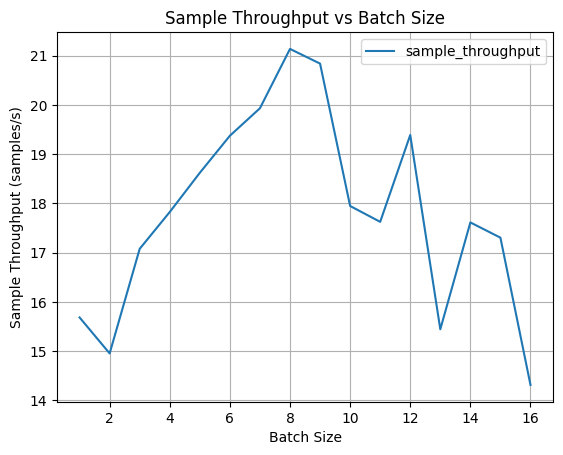

In [21]:
df['sample_throughput'].plot(
    title='Sample Throughput vs Batch Size',
    xlabel='Batch Size',
    ylabel='Sample Throughput (samples/s)',
    grid=True,
    legend=True
)

<Axes: title={'center': 'Batch Throughput vs Batch Size'}, xlabel='Batch Size', ylabel='Batch Throughput (batches/s)'>

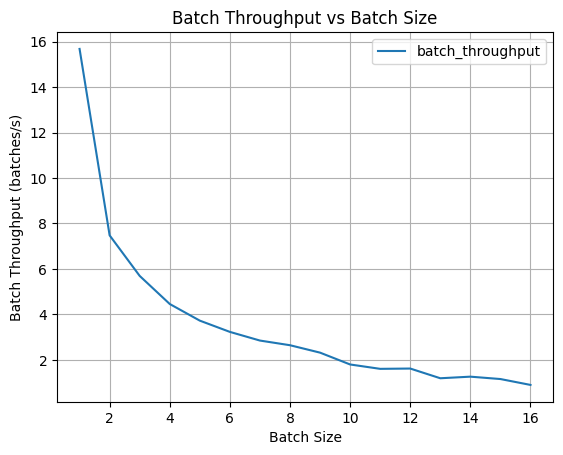

In [22]:
df['batch_throughput'].plot(
    title='Batch Throughput vs Batch Size',
    xlabel='Batch Size',
    ylabel='Batch Throughput (batches/s)',
    grid=True,
    legend=True
)

<Axes: title={'center': 'ETA vs Batch Size'}, xlabel='Batch Size', ylabel='ETA (minutes)'>

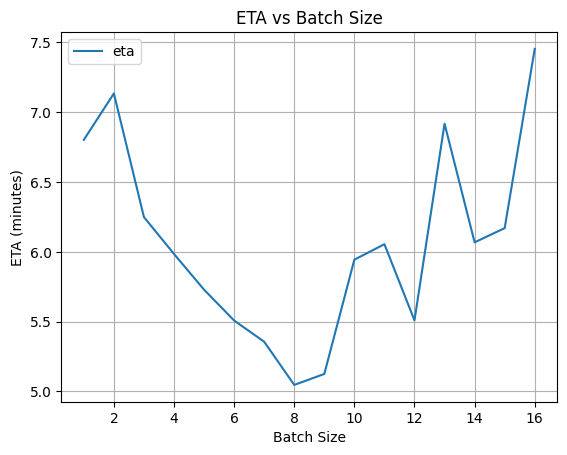

In [23]:
df['eta'].plot(
    title='ETA vs Batch Size',
    xlabel='Batch Size',
    ylabel='ETA (minutes)',
    grid=True,
    legend=True
)